In [ ]:
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.9/310.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install datasets

In [ ]:
import copy
import numpy as np
import json
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import Dataset
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
import torch
from transformers import TrainingArguments
from transformers import Trainer
from dataclasses import dataclass
from datasets import load_dataset
import random
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union,Any, Dict, List

In [ ]:
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is

Found existing installation: unsloth 2024.12.2
Uninstalling unsloth-2024.12.2:
  Successfully uninstalled unsloth-2024.12.2
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-req-build-5_32m3zh
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-req-build-5_32m3zh
  Resolved https://github.com/unslothai/unsloth.git to commit 9dc399a6b6625ee40835c5eab361426d3c5d4abb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2024.12.2-py3-none-any.whl size=167667 sha256=b6227f4bf123c3a394a7de116952e613453e5403019159b6b5bb5062ed432bc5
  Stored in directory: /tmp/pip-ephem-wheel-cache-3h1cz4mc/wheels/ed/d4/e9/76fb290ee3df0a5fc21ce5c2c788e29e9607a2353d8342fd0d
Successfully built unsloth


In [ ]:
from unsloth import FastLanguageModel
from unsloth import is_bfloat16_supported

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import login
login("")

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/train_mcqa.csv')

In [ ]:
def calculate_accuracy(results, data):
    correct_predictions = 0
    total_questions = 0

    for result, entry in zip(results, data["data"]):
        correct_option = entry.get("correct_option")
        if not correct_option:
            continue  # Skip if the correct option is not available

        total_questions += 1  # Increment total questions for every entry

        # Check if predicted_options is non-empty
        if result["predicted_options"]:
            # Get the top 1 predicted option
            predicted_option = result["predicted_options"][0]

            if predicted_option == correct_option:
                correct_predictions += 1
        else:
            # Count empty predictions as incorrect
            print(f"No prediction for question ID: {entry['id']}")

    # Calculate accuracy
    accuracy = correct_predictions / total_questions if total_questions > 0 else 0.0
    return accuracy

In [ ]:
def calculate_map_at_k(results, data, k=3):
    average_precisions = []

    for result, entry in zip(results, data["data"]):
        correct_option = entry.get("correct_option")
        if not correct_option:
            continue  # Skip if the correct option is not available

        predicted_options = result["predicted_options"]
        try:
            rank = predicted_options.index(correct_option) + 1
            average_precision = 1.0 / rank
        except ValueError:
            average_precision = 0.0  # Correct option not in top k

        average_precisions.append(average_precision)

    # Compute MAP@k
    map_at_k = sum(average_precisions) / len(average_precisions) if average_precisions else 0.0
    return map_at_k

In [ ]:
def move_correct_answer_to_target_option(entry, target_option_label):
    option_labels = ['A', 'B', 'C', 'D', 'E']
    options = entry["options"]
    correct_answer = entry["correct_option"]

    # Ensure the correct answer exists in options
    if correct_answer not in options:
        return None  # Skip if the correct answer is not found

    # Create a new options dictionary with the correct answer moved
    new_options = {}
    for label in option_labels:
        if label == target_option_label:
            new_options[label] = options[correct_answer]
        elif label == correct_answer:
            new_options[label] = options[target_option_label] if target_option_label in options else ''
        else:
            new_options[label] = options.get(label, '')

    # Update the correct answer label
    new_entry = entry.copy()
    new_entry["options"] = new_options
    new_entry["correct_option"] = target_option_label
    return new_entry
def transform_data(data, target_option_label):
    transformed_data = {"data": []}
    for entry in data["data"]:
        new_entry = move_correct_answer_to_target_option(entry, target_option_label)
        if new_entry is not None:
            transformed_data["data"].append(new_entry)
    return transformed_data

def calculate_mu_bias_with_model(model, tokenizer, data):
    option_labels = ['A', 'B', 'C', 'D', 'E']

    # Compute Acc0 using your inference results
    Acc_0 = compute_accuracy(inference_result, data)
    print(f"Original Accuracy (Acc0): {Acc_0}")

    Acc_list = []
    for target_option_label in option_labels:
        # Move the correct answers to the target option for all questions
        data_moved = {"data": []}
        for entry in data["data"]:
            new_entry = move_correct_answer_to_target_option(entry, target_option_label)
            if new_entry is not None:
                data_moved["data"].append(new_entry)

        # Re-run inference on the modified data
        results_i = make_inference_on_mcqa_batch(model, tokenizer, data_moved)

        # Compute accuracy after the answer-moving attack
        Acc_i = compute_accuracy(results_i, data_moved)
        Acc_list.append(Acc_i)
        print(f"Accuracy after moving correct answers to option '{target_option_label}' (Acc_i): {Acc_i}")

    # Calculate μ_bias
    Acc_diffs = [abs(Acc_i - Acc_0) for Acc_i in Acc_list]
    mu_bias = sum(Acc_diffs) / len(option_labels)
    print(f"μ_bias: {mu_bias}")
    return mu_bias

Loading model from HuggingFace

In [ ]:
model_id = "meta-llama/Llama-3.2-3B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Step 2: Load the JSON data (modify path to where your file is)
json_file_path = '/content/drive/MyDrive/formatted_training_data.json'  # Update path for Colab
with open(json_file_path, 'r') as f:
    data = json.load(f)

In [ ]:
def make_inference_on_mcqa_mcp_generate2(model, tokenizer, data, k=1):
    results = []

    # Ensure the model is in evaluation mode
    model.eval()
    device = next(model.parameters()).device
    option_labels = ['A', 'B', 'C', 'D', 'E']

    for entry in data["data"]:
        prompt = entry["prompt"]
        question = entry["question"]
        options = entry["options"]

        # Construct the input prompt including all options
        input_prompt = f"{prompt}\n\nQuestion: {question}\n\nOptions:\n"
        available_option_labels = []
        for label in option_labels:
            if label in options and options[label]:
                option_text = options[label]
                input_prompt += f"{label}) {option_text}\n"
                available_option_labels.append(label)

        input_prompt += "\nAnswer:"

        # Tokenize input prompt without truncation
        inputs = tokenizer(
            input_prompt,
            return_tensors="pt",
            truncation=False,
            max_length=1024
        ).to(device)

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        # Generate output sequences using beam search
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                num_beams=5,             # Number of beams for beam search
                max_new_tokens=50,       # Maximum number of tokens to generate
                num_return_sequences=min(k, 5),  # Return up to k sequences
                early_stopping=True,
                do_sample=False          # Disable sampling to use beam search
            )

        # Decode the generated sequences and extract predicted labels
        predicted_labels = []
        for output in outputs:
            # Get the generated tokens after the input prompt
            generated_tokens = output[input_ids.shape[1]:]
            generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()

            # Extract the predicted label (assuming it's the first non-empty token)
            predicted_label = generated_text.split()[0]

            if predicted_label in available_option_labels and predicted_label not in predicted_labels:
                predicted_labels.append(predicted_label)
                if len(predicted_labels) >= k:
                    break  # We have enough predictions

        # If no valid labels are predicted, you can handle it accordingly
        if not predicted_labels:
            result = {
                "id": entry["id"],
                "question": question,
                "predicted_options": []
            }
        else:
            result = {
                "id": entry["id"],
                "question": question,
                "predicted_options": predicted_labels  # List of top k predicted labels
            }

        results.append(result)

    return results

In [ ]:
def make_inference_on_mcqa_mcp_generate(model, tokenizer, data, k=1):
    results = []

    # Ensure the model is in evaluation mode
    model.eval()
    device = next(model.parameters()).device
    option_labels = ['A', 'B', 'C', 'D', 'E']

    for entry in data["data"]:
        prompt = entry["prompt"]
        question = entry["question"]
        options = entry["options"]

        input_prompt = f"{prompt}\n\nQuestion: {question}\n\nOptions:\n"
        available_option_labels = []
        for label in option_labels:
            if label in options and options[label]:
                option_text = options[label]
                input_prompt += f"{label}) {option_text}\n"
                available_option_labels.append(label)

        input_prompt += "\nAnswer:"

        # Tokenize input prompt without truncation
        inputs = tokenizer(
            input_prompt,
            return_tensors="pt",
            truncation=False
        ).to(device)

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        # Find the index after 'Answer:' in the input prompt
        answer_str_index = input_prompt.find('Answer:')
        if answer_str_index == -1:
            print(f"'Answer:' not found in the prompt for question ID {entry['id']}")
            result = {
                "id": entry["id"],
                "question": question,
                "predicted_options": []
            }
            results.append(result)
            continue

        # Tokenize the prompt up to 'Answer:' to find the position
        partial_prompt = input_prompt[:answer_str_index + len('Answer:')]
        partial_inputs = tokenizer(
            partial_prompt,
            return_tensors="pt",
            truncation=False
        ).to(device)
        answer_end_index = partial_inputs['input_ids'].shape[1] - 1  # Position after 'Answer:'

        # Ensure the index is within bounds
        if answer_end_index >= inputs['input_ids'].shape[1]:
            print(f"Next token index {answer_end_index} out of bounds for question ID {entry['id']}")
            result = {
                "id": entry["id"],
                "question": question,
                "predicted_options": []
            }
            results.append(result)
            continue

        # Get the logits for the next token after 'Answer:'
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Shape: [batch_size, seq_length, vocab_size]

        next_token_logits = logits[0, answer_end_index, :]  # Shape: [vocab_size]

        # Map labels to their token IDs
        label_token_ids = []
        for label in available_option_labels:
            label_token_id = tokenizer.encode(label, add_special_tokens=False)
            if len(label_token_id) > 0:
                label_token_ids.append((label, label_token_id))
            else:
                print(f"Label '{label}' tokenization failed for question ID {entry['id']}")

        if not label_token_ids:
            print(f"No valid labels for question ID {entry['id']}")
            result = {
                "id": entry["id"],
                "question": question,
                "predicted_options": []
            }
            results.append(result)
            continue

        # Extract logits for the label tokens
        label_logits = []
        for label, token_ids in label_token_ids:
            logit = sum([next_token_logits[tid].item() for tid in token_ids])
            label_logits.append(logit)
        label_logits = torch.tensor(label_logits)

        # Apply softmax to get probabilities
        label_probs = torch.softmax(label_logits, dim=0)

        # Get the indices of the top k probabilities
        top_k = min(k, len(label_probs))  # Ensure k does not exceed available options
        topk_probs, topk_indices = torch.topk(label_probs, top_k)

        # Get the corresponding labels
        predicted_labels = [label_token_ids[idx][0] for idx in topk_indices]

        result = {
            "id": entry["id"],
            "question": question,
            "predicted_options": predicted_labels  # List of top k predicted labels
        }
        results.append(result)

    return results

In [ ]:
def make_inference_on_mcqa_cloze(model, tokenizer, data, k):
    results = []

    # Ensure the model is in evaluation mode
    model.eval()

    # Move the model to the appropriate device
    device = next(model.parameters()).device

    option_labels = ['A', 'B', 'C', 'D', 'E']

    # Since the dataset is small, process each question individually
    for entry in data["data"]:
        prompt = entry["prompt"]
        question = entry["question"]
        options = entry["options"]

        # Prepare input texts and available option labels
        input_texts = []
        available_option_labels = []
        for label in option_labels:
            if label in options and options[label]:
                option_text = options[label]
                input_text = f"{prompt} {question} Option {label}: {option_text}"
                input_texts.append(input_text)
                available_option_labels.append(label)

        if not input_texts:
            continue  # Skip if there are no valid options

        # Tokenize all options for the current question
        inputs = tokenizer(
            input_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)

        # Run the model on the options
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            input_ids = inputs["input_ids"]

            # Compute log probabilities
            log_probs = torch.log_softmax(logits, dim=-1)
            gathered_log_probs = log_probs.gather(2, input_ids.unsqueeze(-1)).squeeze(-1)
            total_log_probs = gathered_log_probs.sum(dim=1).cpu().numpy()

        # Get the indices sorted by score in descending order
        sorted_indices = np.argsort(-total_log_probs)

        # Select the top option(s)
        top_k = k  # Change to 3 if you want top 3 options
        top_indices = sorted_indices[:top_k]
        predicted_options = [available_option_labels[i] for i in top_indices]

        result = {
            "id": entry["id"],
            "question": question,
            "predicted_options": predicted_options  # List of top options
        }
        results.append(result)

    return results



*   100mins for CPU
*   44s for A100 inference for 200 questions, 19mins for Cloze inference, 10mins for MCP inference





In [ ]:
inference_results1=make_inference_on_mcqa_mcp_generate(model, tokenizer, data, k=3)

In [ ]:
inference_results2=make_inference_on_mcqa_mcp_generate2(model, tokenizer, data, k=3)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

In [ ]:
inference_results = make_inference_on_mcqa_cloze(model, tokenizer, data,3)

In [ ]:
accuracy=calculate_accuracy(inference_results, data)
print(f"Accuracy: {accuracy}")

Accuracy: 0.305


In [ ]:
accuracy2=calculate_accuracy(inference_results2, data)
print(f"Accuracy: {accuracy2}")

No prediction for question ID: Q28
No prediction for question ID: Q190
Accuracy: 0.535


In [ ]:
MAP33=calculate_map_at_k(inference_results2, data, k=3)
print(f"MAP@3: {MAP33}")

MAP@3: 0.6499999999999999


In [ ]:
accuracy=calculate_accuracy(inference_results1, data)
print(f"Accuracy: {accuracy}")

Accuracy: 0.56


In [ ]:
MAP32=calculate_map_at_k(inference_results1, data, k=3)
print(f"MAP@3: {MAP32}")

MAP@3: 0.6741666666666662


In [ ]:
accuracy=calculate_accuracy(inference_results, data)
print(f"Accuracy: {accuracy}")

Accuracy: 0.305


In [ ]:
MAP3=calculate_map_at_k(inference_results, data, k=3)
print(f"MAP@3: {MAP3}")

MAP@3: 0.4633333333333331


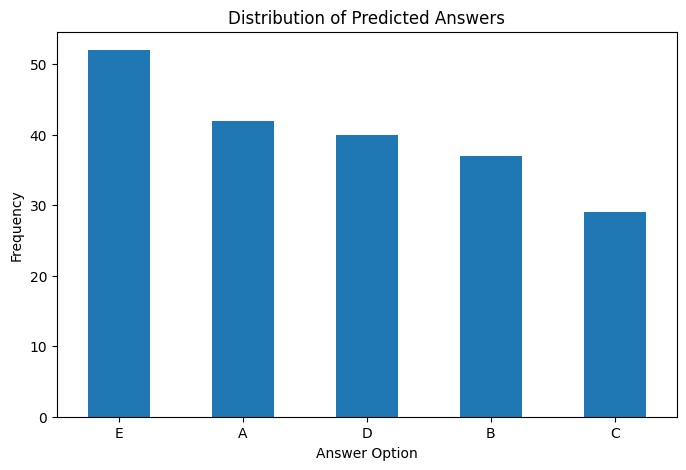

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the inference results to a DataFrame
df = pd.DataFrame(inference_results)

# Count occurrences of each predicted option
option_counts = df['predicted_option'].value_counts()

# Plot the distribution of predicted options
plt.figure(figsize=(8, 5))
option_counts.plot(kind='bar')
plt.title('Distribution of Predicted Answers')
plt.xlabel('Answer Option')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [ ]:
inference_results_dict = {}
data_moved_dict = {}

option_labels = ['A', 'B', 'C', 'D', 'E']
Acc_list = []

for target_option_label in option_labels:
    # Transform data
    transformed_data = transform_data(data, target_option_label)
    data_moved_dict[target_option_label] = transformed_data

    # Run inference
    results = make_inference_on_mcqa_batch(model, tokenizer, transformed_data,1)
    inference_results_dict[target_option_label] = results

    # Compute accuracy
    Acc_i = calculate_accuracy(results, transformed_data)
    Acc_list.append(Acc_i)
    print(f"Accuracy when correct answers are moved to '{target_option_label}': {Acc_i}")

Accuracy when correct answers are moved to 'A': 0.33
Accuracy when correct answers are moved to 'B': 0.26
Accuracy when correct answers are moved to 'C': 0.24
Accuracy when correct answers are moved to 'D': 0.33
Accuracy when correct answers are moved to 'E': 0.415


In [ ]:
inference_results_dict = {}
data_moved_dict = {}

option_labels = ['A', 'B', 'C', 'D', 'E']
Acc_list = []

for target_option_label in option_labels:
    # Transform data
    transformed_data = transform_data(data, target_option_label)
    data_moved_dict[target_option_label] = transformed_data

    # Run inference
    results = make_inference_on_mcqa_mcp_generate(model, tokenizer, transformed_data,1)
    inference_results_dict[target_option_label] = results

    # Compute accuracy
    Acc_i = calculate_accuracy(results, transformed_data)
    Acc_list.append(Acc_i)
    print(f"Accuracy when correct answers are moved to '{target_option_label}': {Acc_i}")

Accuracy when correct answers are moved to 'A': 0.52
Accuracy when correct answers are moved to 'B': 0.665
Accuracy when correct answers are moved to 'C': 0.52
Accuracy when correct answers are moved to 'D': 0.84
Accuracy when correct answers are moved to 'E': 0.035


initial μ_bias: 5.3

MCQ bias:μ_bias: 0.198. 19.8

In [ ]:
# Calculate μ_bias
Acc_0=0.56
Acc_diffs = [abs(Acc_i - Acc_0) for Acc_i in Acc_list]
mu_bias = sum(Acc_diffs) / len(option_labels)
print(f"μ_bias: {mu_bias}")

In [ ]:
Acc_0=0.56
Acc_diffs = [abs(Acc_i - Acc_0) for Acc_i in Acc_list]
mu_bias = sum(Acc_diffs) / len(option_labels)
print(f"μ_bias: {mu_bias}")

μ_bias: 0.198


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
accuracies = {}
for option, transformed_data in transformed_datasets.items():
    predictions = make_inference_on_mcqa(transformed_data)
    predictions_df = pd.DataFrame(predictions)
    accuracy_merged_df = pd.merge(predictions_df, correct_answers_df, on='id')
    accuracy = (accuracy_merged_df['predicted_option'] == accuracy_merged_df['Correct Answer']).mean()
    accuracies[option] = accuracy
    print(f"Accuracy with correct answer in position {option}: {accuracy}")

Accuracy with correct answer in position A: 0.195
Accuracy with correct answer in position B: 0.225
Accuracy with correct answer in position C: 0.2
Accuracy with correct answer in position D: 0.225
Accuracy with correct answer in position E: 0.255


Initial Mean Bias (µbias): 9.5

In [ ]:
original_accuracy = (merged_df['predicted_option'] == merged_df['Correct Answer']).mean()
mean_bias = sum(abs(acc - original_accuracy) for acc in accuracies.values()) / len(accuracies) *100
print(f"Mean Bias (µbias): {mean_bias}")

Mean Bias (µbias): 9.5


# Training

In [ ]:
from datasets import Dataset

In [ ]:
def prepare_sequences_with_symbol_and_content(row):
    prompt = row['prompt']
    choices = {
        'A': row['A'],
        'B': row['B'],
        'C': row['C'],
        'D': row['D'],
        'E': row['E']
    }
    answer_symbol = row['answer']  # This will be 'A', 'B', 'C', 'D', or 'E'
    answer_content = choices[answer_symbol]
    correct_answer = f"{answer_symbol}) {answer_content}"

    # Create the options text
    options_text = '\n'.join([f"{symbol}) {content}" for symbol, content in choices.items()])

    # Create the input sequence
    input_sequence = f"Question: {prompt}\nOptions:\n{options_text}\nAnswer:"

    # The target output is the symbol and content of the correct answer
    target_output = correct_answer

    return input_sequence, target_output
def tokenize_function(examples):
    model_inputs = tokenizer(
        examples['input_sequence'],
        max_length=2048,
        truncation=True,
        padding=True,  # Do not pad here
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples['target_output'],
            max_length=512,
            truncation=True,
            padding=True,  # Do not pad here
        )
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [ ]:
input_sequences = []
target_outputs = []

for index, row in train.iterrows():
    input_seq, target_output = prepare_sequences_with_symbol_and_content(row)
    input_sequences.append(input_seq)
    target_outputs.append(target_output)

In [ ]:
data_dict = {
    'input_sequence': input_sequences,
    'target_output': target_outputs,
}
hf_dataset = Dataset.from_dict(data_dict)
tokenized_dataset = hf_dataset.map(tokenize_function, batched=True, remove_columns=['input_sequence', 'target_output'])

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding='longest'
)

In [ ]:
def create_prompt(row):
    prompt = (
        "Answer the following question by selecting one of the options. "
        "Your response should be in the format {option}, where {option} is A, B, C, D, or E.\n\n"
        f"Question: {row['prompt']}\n"
        "Options:\n"
        f"A) {row['A']}\n"
        f"B) {row['B']}\n"
        f"C) {row['C']}\n"
        f"D) {row['D']}\n"
        f"E) {row['E']}\n"  # Include option E if applicable
        "Answer:"
    )
    return prompt
# Prepare the prompts and answers
train['prompt'] = train.apply(create_prompt, axis=1)
train['answer_text'] = train['answer'].str.strip().str.upper()
# Create the dataset
dataset = Dataset.from_pandas(train[['prompt', 'answer_text']])

# Tokenize the data
def tokenize_function(examples):
    prompts = examples['prompt']
    answers = examples['answer_text']

    # Tokenize the prompts
    tokenized_prompts = tokenizer(
        prompts,
        padding='max_length',  # Ensure consistent length
        truncation=False,
        max_length=1024,  # Adjust based on your requirements
        return_attention_mask=True
    )

    # Prepare answer contents with symbols
    answer_contents = []
    for i in range(len(answers)):
        symbol = answers[i] + ')'  # Ensure symbols are added (e.g., 'D)')
        content = train.loc[i, answers[i]]  # Extract the content corresponding to the symbol
        answer_contents.append(f"{symbol} {content}")  # Combine symbol + content

    # Tokenize the answers
    tokenized_answers = tokenizer(
        answer_contents,
        padding='max_length',  # Ensure consistent length
        truncation=False,
        max_length=512,  # Adjust based on symbol + content length
        return_attention_mask=True
    )

    # Create labels
    labels = []
    for i in range(len(prompts)):
        # Number of tokens in the prompt (non-padded)
        prompt_length = sum(tokenized_prompts['attention_mask'][i])

        # Create a list of -100 for the prompt tokens
        label = [-100] * prompt_length

        # Get the answer token IDs, removing padding
        answer_ids = [
            token_id for token_id in tokenized_answers['input_ids'][i]
            if token_id != tokenizer.pad_token_id
        ]

        # Append answer tokens to labels
        label += answer_ids

        # Truncate or pad labels to match max_length
        label = label[:512] + [-100] * (512 - len(label))
        labels.append(label)

    return {
        'input_ids': tokenized_prompts['input_ids'],
        'attention_mask': tokenized_prompts['attention_mask'],
        'labels': labels
    }
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# Function to decode input_ids and labels
def decode_example(example, tokenizer):
    input_text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
    label_ids = example['labels']

    # Replace -100 with pad_token_id for decoding labels
    label_ids_decodable = [token_id if token_id != -100 else tokenizer.pad_token_id for token_id in label_ids]
    label_text = tokenizer.decode(label_ids_decodable, skip_special_tokens=True)

    return {
        'input_text': input_text,
        'label_text': label_text
    }

# Decode the first two examples
decoded_examples = [decode_example(tokenized_dataset[i], tokenizer) for i in range(2)]

for idx, example in enumerate(decoded_examples):
    print(f"Example {idx+1}:")
    print("Input Text:")
    print(example['input_text'])
    print("\nLabel Text:")
    print(example['label_text'])
    print("-" * 50)

Example 1:
Input Text:
Question: Which of the following statements accurately describes the impact of Modified Newtonian Dynamics (MOND) on the observed "missing baryonic mass" discrepancy in galaxy clusters?
Options:
A) MOND is a theory that reduces the observed missing baryonic mass in galaxy clusters by postulating the existence of a new form of matter called "fuzzy dark matter."
B) MOND is a theory that increases the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 20.
C) MOND is a theory that explains the missing baryonic mass in galaxy clusters that was previously considered dark matter by demonstrating that the mass is in the form of neutrinos and axions.
D) MOND is a theory that reduces the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 2.
E) MOND is a theor

In [ ]:
split_tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
tokenized_train_dataset = split_tokenized_dataset['train']
tokenized_valid_dataset = split_tokenized_dataset['test']

In [ ]:
tokenized_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 200
})

In [ ]:
# Remove labels and test forward pass
inputs_no_labels = {k: v for k, v in inputs.items() if k != "labels"}
outputs = model.forward(**inputs_no_labels)
print("Logits from forward without labels:", outputs.logits)

Logits from forward without labels: tensor([[[ 3.4375,  3.1562,  3.4375,  ..., -4.9375, -4.9375, -4.9375],
         [ 6.1875,  4.6250,  4.5938,  ..., -4.0938, -4.0938, -4.0938],
         [ 8.4375,  8.1875,  7.0625,  ..., -4.7812, -4.7812, -4.7812],
         [12.0625, 10.0625, 12.3750,  ..., -4.6250, -4.6250, -4.6250]]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)


In [ ]:
outputs = model(**inputs, return_dict=True)
print("Loss:", outputs.loss)
print("Logits:", outputs.logits)

Loss: tensor(9.1318, device='cuda:0', grad_fn=<LinearCrossEntropyFunctionBackward>)
Logits: None


In [ ]:
print(model.forward)

<bound method convert_outputs_to_fp32.<locals>.forward of LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaExtendedRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (p

In [ ]:
# Test how the tokenizer handles the symbols
symbols = ['A', 'B', 'C', 'D', 'E']
for symbol in symbols:
    token_ids = tokenizer.encode(symbol, add_special_tokens=False)
    tokens = tokenizer.convert_ids_to_tokens(token_ids)
    print(f"Symbol: {symbol}, Tokens: {tokens}")

Symbol: A, Tokens: ['A']
Symbol: B, Tokens: ['B']
Symbol: C, Tokens: ['C']
Symbol: D, Tokens: ['D']
Symbol: E, Tokens: ['E']


In [ ]:
sequences = ['A:', 'A)']
for seq in sequences:
    token_ids = tokenizer.encode(seq, add_special_tokens=False)
    tokens = tokenizer.convert_ids_to_tokens(token_ids)
    print(f"Sequence: {seq}, Tokens: {tokens}")

Sequence: A:, Tokens: ['A', ':']
Sequence: A), Tokens: ['A', ')']


In [ ]:
class RSCBDataset(Dataset):
    def __init__(self, samples, tokenizer, max_length=2048):
        if isinstance(samples, pd.DataFrame):
            self.samples = samples.to_dict(orient='records')
        else:
            self.samples = samples
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
      if isinstance(idx, int):
          return self.process_sample(self.samples[idx])
      elif isinstance(idx, list):
          batch = {}
          # Initialize lists for each key in the sample
          keys = ['input_ids', 'attention_mask', 'labels', 'symbol_mask', 'symbol_token_id']
          for key in keys:
              batch[key] = []
          # Process each sample and collect the results
          for i in idx:
              sample = self.process_sample(self.samples[i])
              for key in keys:
                  batch[key].append(sample[key])
          return batch
      else:
          raise TypeError(f"Unsupported index type: {type(idx)}")

    def process_sample(self, sample):
        # Construct the input_text
        input_text = sample['prompt'] + "\n"
        for option_label in ['A', 'B', 'C', 'D', 'E']:
            option_text = sample.get(option_label, "")
            if option_text:
                input_text += f"{option_label}: {option_text}\n"

        input_text += "Answer:\n"

        # Construct the output_text
        correct_option_label = sample['answer']
        correct_option_text = sample.get(correct_option_label, "")
        output_text = f"{correct_option_label}: {correct_option_text}"

        # Concatenate input and output for causal language modeling
        full_text = input_text + output_text

        # Tokenize full text
        encoding = self.tokenizer(
            full_text,
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        # Create labels
        labels = input_ids.clone()
        # Mask input tokens
        input_prefix_length = len(self.tokenizer.encode(input_text, add_special_tokens=False))
        labels[:input_prefix_length] = -100  # Mask input tokens

        # Identify the symbol token in the output
        output_ids = input_ids[input_prefix_length:]
        # The first token in the output should be the symbol (e.g., 'D')
        symbol_token_id = output_ids[0]
        symbol_mask = torch.zeros_like(labels, dtype=torch.bool)
        symbol_position = input_prefix_length  # Position of the symbol token
        symbol_mask[symbol_position] = True

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'symbol_mask': symbol_mask,
            'symbol_token_id': symbol_token_id  # For computing p_s
        }

In [ ]:
def data_collator(features):
    batch = {}
    keys = features[0].keys()
    for key in keys:
        sequences = [feature[key] for feature in features]
        if key == 'input_ids':
            padding_value = tokenizer.pad_token_id
            batch[key] = torch.nn.utils.rnn.pad_sequence(
                sequences, batch_first=True, padding_value=padding_value
            )
        elif key == 'labels':
            padding_value = -100
            batch[key] = torch.nn.utils.rnn.pad_sequence(
                sequences, batch_first=True, padding_value=padding_value
            )
        elif key in ['attention_mask', 'symbol_mask']:
            padding_value = 0
            batch[key] = torch.nn.utils.rnn.pad_sequence(
                sequences, batch_first=True, padding_value=padding_value
            )
        elif key == 'symbol_token_id':
            batch[key] = torch.stack(sequences)
    return batch

In [ ]:
class RSCBTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop('labels')
        symbol_mask = inputs.pop('symbol_mask').to(model.device)
        symbol_token_id = inputs.pop('symbol_token_id').to(model.device)

        outputs = model(**inputs, labels=labels)
        logits = outputs.logits  # Shape: (batch_size, sequence_length, vocab_size)

        # Shift logits and labels for causal language modeling
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        symbol_mask = symbol_mask[..., 1:].contiguous()

        # Flatten the tokens
        loss_fct = torch.nn.CrossEntropyLoss(reduction='none', ignore_index=-100)
        loss = loss_fct(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        )
        loss = loss.view(shift_labels.size())

        # Compute L_SCB (standard CrossEntropyLoss over all output tokens)
        l_scb = loss.mean()

        # Compute p_s (predicted probability of the symbol token)
        # Identify positions where symbol_mask is True
        symbol_positions = symbol_mask.nonzero(as_tuple=True)
        symbol_logits = shift_logits[symbol_positions]  # Shape: (num_symbols, vocab_size)
        symbol_probs = torch.softmax(symbol_logits, dim=-1)  # Get probabilities
        p_s = symbol_probs.gather(1, symbol_token_id.unsqueeze(-1)).squeeze(-1)  # Shape: (num_symbols,)

        # Compute the additional loss term
        alpha = 2.0  # Focusing parameter (adjust as needed)
        beta = 0.1   # Re-assigned weight for the symbol token (adjust as needed)

        # Compute the Focal Loss component
        focal_weight = (1 - p_s) ** alpha
        symbol_loss = focal_weight * beta * (-torch.log(p_s + 1e-8))  # Add epsilon to prevent log(0)

        # Total loss
        loss = l_scb + symbol_loss.mean()

        if return_outputs:
            return loss, outputs
        else:
            return loss

In [ ]:
dataset = RSCBDataset(train, tokenizer, max_length=2048)

In [ ]:
training_args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 100,
        learning_rate = 2e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
        remove_unused_columns=False,
        dataloader_num_workers=0,# Use this for WandB etc
    )
# Initialize trainer
trainer = RSCBTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=data_collator,
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
import os
os.environ['UNSLOTH_RETURN_LOGITS'] = '1'

In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 200 | Num Epochs = 4
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 100
 "-____-"     Number of trainable parameters = 2,818,747,392


Step,Training Loss
1,4.477200
2,4.302700
3,3.073400
4,1.104400
5,0.144000
6,0.071200
7,0.047700
8,0.036200
9,0.021600
10,0.020300


TrainOutput(global_step=100, training_loss=0.1382784746706966, metrics={'train_runtime': 104.2246, 'train_samples_per_second': 7.676, 'train_steps_per_second': 0.959, 'total_flos': 3966823204761600.0, 'train_loss': 0.1382784746706966, 'epoch': 4.0})

In [ ]:
symbol_tokens = ['A', 'B', 'C', 'D', 'E']
special_tokens = {'additional_special_tokens': symbol_tokens}
num_added_tokens = tokenizer.add_special_tokens(special_tokens)
print(f"Added {num_added_tokens} new tokens.")
symbol_token_ids = tokenizer.convert_tokens_to_ids(symbol_tokens)
print("Symbol Token IDs:", symbol_token_ids)

# 4. Verify Single-Token Symbols
for symbol in symbol_tokens:
    token_ids = tokenizer.encode(symbol, add_special_tokens=False)
    print(f"Symbol: {symbol}, Token IDs: {token_ids}")
    assert len(token_ids) == 1, f"Symbol '{symbol}' is tokenized into multiple tokens: {token_ids}"
model.resize_token_embeddings(len(tokenizer))
def create_symbol_mask(labels, symbol_token_ids):
    labels_tensor = torch.tensor(labels)
    symbol_token_ids_tensor = torch.tensor(symbol_token_ids).to(labels_tensor.device)
    symbol_mask = torch.isin(labels_tensor, symbol_token_ids_tensor)
    return symbol_mask

def compute_rscb_loss(logits, labels, symbol_mask, alpha=2.0, beta=1.0):
    """
    Computes the Reweighting Symbol-Content Binding (RSCB) loss.

    Args:
        logits (torch.Tensor): Logits from the model of shape (batch_size, seq_length, vocab_size).
        labels (torch.Tensor): Ground truth labels of shape (batch_size, seq_length).
        symbol_mask (torch.Tensor): Binary mask indicating symbol tokens of shape (batch_size, seq_length).
        alpha (float): Exponent for reweighting.
        beta (float): Weighting factor for the symbol tokens.

    Returns:
        torch.Tensor: The computed RSCB loss.
    """
    # Flatten the tensors
    logits_flat = logits.view(-1, logits.size(-1))  # (batch_size * seq_length, vocab_size)
    labels_flat = labels.view(-1)  # (batch_size * seq_length)
    symbol_mask_flat = symbol_mask.view(-1)  # (batch_size * seq_length)

    # Compute standard cross-entropy loss without reduction
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100, reduction='none')
    ce_loss = loss_fn(logits_flat, labels_flat)  # (batch_size * seq_length)

    # Compute probabilities
    probs = torch.softmax(logits_flat, dim=-1)  # (batch_size * seq_length, vocab_size)
    target_probs = probs[torch.arange(probs.size(0)), labels_flat]  # (batch_size * seq_length)

    # Identify valid indices (labels not ignored)
    valid_indices = labels_flat != -100
    target_probs = target_probs[valid_indices]  # (num_valid)
    symbol_mask_flat = symbol_mask_flat[valid_indices]  # (num_valid)

    # Extract probabilities for symbol tokens
    ps = target_probs[symbol_mask_flat.bool()]  # (num_symbol_tokens)

    # Compute the RSCB additional loss term
    rscb_term = (1 - ps) ** alpha * beta * (-torch.log(ps))  # (num_symbol_tokens)

    # Aggregate the losses
    # Start with the standard cross-entropy loss for valid indices
    total_loss = ce_loss[valid_indices].clone()  # (num_valid)

    # Add the RSCB term only to symbol tokens
    total_loss[symbol_mask_flat.bool()] += rscb_term  # (num_valid)

    # Compute the mean loss
    mean_loss = total_loss.mean()
    return mean_loss

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Added 5 new tokens.
Symbol Token IDs: [128256, 128257, 128258, 128259, 128260]
Symbol: A), Token IDs: [128256]
Symbol: B), Token IDs: [128257]
Symbol: C), Token IDs: [128258]
Symbol: D), Token IDs: [128259]
Symbol: E), Token IDs: [128260]


In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, symbol_token_ids, alpha=2.0, beta=2.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.symbol_token_ids = symbol_token_ids
        self.alpha = alpha
        self.beta = beta

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):

      labels = inputs.get("labels")
      if labels is None:
          raise ValueError("Labels are missing from the inputs.")
      inputs_without_labels = {k: v for k, v in inputs.items() if k != "labels"}
      outputs = model(**inputs_without_labels)
    # Forward pass
      #outputs = model(**inputs)
      #print("Outputs:", outputs)  # Debug the outputs

      logits = outputs.logits if hasattr(outputs, "logits") else outputs.get("logits", None)
      if logits is None:
          raise ValueError("Logits are missing from the model outputs.")

    # Create symbol mask
      symbol_mask = create_symbol_mask(labels, self.symbol_token_ids).to(labels.device)

    # Compute custom RSCB loss
      loss = compute_rscb_loss(
          logits,
          labels,
          symbol_mask,
          alpha=self.alpha,
          beta=self.beta,
      )

      return (loss, outputs) if return_outputs else loss

In [ ]:
# Example input
tokenized_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 200
})

In [ ]:
training_args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 100,
        learning_rate = 2e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
        remove_unused_columns=False,# Use this for WandB etc
    )

# Initialize the CustomTrainer
trainer = CustomTrainer(
    model=model,
    tokenizer=tokenizer,
    symbol_token_ids=symbol_token_ids,
    alpha=2.0,                        # Adjust based on hyperparameter tuning
    beta=0.1,                         # Adjust based on hyperparameter tuning
    args=training_args,
    train_dataset=tokenized_dataset,  # Your tokenized dataset
    data_collator=data_collator# Define a data collator if needed
)


<ipython-input-18-98ece5e91428>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
# Sample labels (Assuming 'D' is the correct answer)
sample_labels = tokenizer.encode("D) MOND is a theory that increases the discrepancy between the", add_special_tokens=False)
mask = create_symbol_mask(sample_labels, symbol_token_ids)
print(f"Sample Labels: {sample_labels}")
print(f"Symbol Mask: {mask}")
print(f"Number of Symbols in Labels: {mask.sum().item()}")

Sample Labels: [128259, 29637, 35, 374, 264, 10334, 430, 12992, 279, 79105, 1990, 279]
Symbol Mask: tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False])
Number of Symbols in Labels: 1


In [ ]:
# Ensure model is on the correct device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Move inputs to the same device as the model
inputs = {key: tensor.to(device) for key, tensor in inputs.items()}

# Pass inputs to the model
outputs = model(**inputs)

In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 200 | Num Epochs = 4
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 100
 "-____-"     Number of trainable parameters = 2,818,747,392
<ipython-input-17-4b813ab6fae8>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(labels)
<ipython-input-17-4b813ab6fae8>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(labels)


Step,Training Loss
1,41.093500
2,40.628600
3,39.172300
4,41.179400
5,40.747800
6,40.317100
7,40.259300
8,39.754300
9,44.506300
10,40.210100


TrainOutput(global_step=100, training_loss=40.75544761657715, metrics={'train_runtime': 129.5987, 'train_samples_per_second': 6.173, 'train_steps_per_second': 0.772, 'total_flos': 8415652213555200.0, 'train_loss': 40.75544761657715, 'epoch': 4.0})

In [ ]:
answer_distribution = train['answer'].value_counts()

# Print the distribution
print(answer_distribution)

answer
B    48
C    44
D    38
A    37
E    33
Name: count, dtype: int64


In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Disable masked language modeling
)

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding='longest',
    label_pad_token_id=-100,
    return_tensors='pt',
)

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = False,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2024.12.2: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.0. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.11.9 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [ ]:
response_template_with_context = "\n### Assistant:"  # We added context here: "\n". This is enough for this tokenizer
response_template_ids = tokenizer.encode(response_template_with_context, add_special_tokens=False)[2:]  # Now we have it like in the dataset texts: `[2277, 29937, 4007, 22137, 29901]`

data_collator = DataCollatorForCompletionOnlyLM(response_template_ids, tokenizer=tokenizer)

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = tokenized_dataset,
    max_seq_length = 2048,
    data_collator = data_collator,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 200 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 24,313,856


Step,Training Loss
1,1.065700
2,1.329000
3,1.264800
4,1.498800
5,1.040800
6,1.389900
7,1.096700
8,1.007500
9,0.883900
10,0.842200


In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

In [ ]:
peft_config = LoraConfig(
    r=8,                        # Rank of the update matrices
    lora_alpha=32,              # Scaling factor
    target_modules=[
    "self_attn.q_proj",
    "self_attn.k_proj",
],  # Modules to apply LoRA to
    lora_dropout=0.05,          # Dropout rate
    bias="none",                # How to handle bias parameters
    task_type="CAUSAL_LM"       # The type of task
)



model = get_peft_model(model, peft_config)

In [ ]:
save_directory = '/content/drive/MyDrive/models/RSCB_LORA_llama3.5'
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/models/RSCB_LORA_llama3.5/tokenizer_config.json',
 '/content/drive/MyDrive/models/RSCB_LORA_llama3.5/special_tokens_map.json',
 '/content/drive/MyDrive/models/RSCB_LORA_llama3.5/tokenizer.json')

In [ ]:
from peft import PeftModel, PeftConfig

In [ ]:
#save_directory = '/content/drive/MyDrive/models/RSCB_LORA_llama3.2'
#lora_model = PeftModel.from_pretrained(model, save_directory)
#tokenizer = AutoTokenizer.from_pretrained(save_directory)
#tokenizer.pad_token = tokenizer.eos_token

In [ ]:
#save_directory = '/content/drive/MyDrive/models/RSCB_LORA_llama3.2'

#model = AutoModelForCausalLM.from_pretrained(save_directory)

# Load the tokenizer
#tokenizer = AutoTokenizer.from_pretrained(save_directory)

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/content/drive/MyDrive/models/RSCB_LORA_llama3.5", # YOUR MODEL YOU USED FOR TRAINING
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = False,
)
FastLanguageModel.for_inference(model)

==((====))==  Unsloth 2024.12.2: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.0. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaExtendedRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)

In [ ]:
inference_results_trained = make_inference_on_mcqa_mcp_generate(model,tokenizer,data,3)

In [ ]:
inference_results_trained

[{'id': 'Q0',
  'question': 'Which of the following statements accurately describes the impact of Modified Newtonian Dynamics (MOND) on the observed "missing baryonic mass" discrepancy in galaxy clusters?',
  'predicted_options': ['D', 'E', 'A']},
 {'id': 'Q1',
  'question': 'Which of the following is an accurate definition of dynamic scaling in self-similar systems?',
  'predicted_options': ['A', 'E', 'B']},
 {'id': 'Q2',
  'question': 'Which of the following statements accurately describes the origin and significance of the triskeles symbol?',
  'predicted_options': ['A', 'C', 'E']},
 {'id': 'Q3',
  'question': 'What is the significance of regularization in terms of renormalization problems in physics?',
  'predicted_options': ['C', 'A', 'E']},
 {'id': 'Q4',
  'question': 'Which of the following statements accurately describes the relationship between the dimensions of a diffracting object and the angular spacing of features in the diffraction pattern?',
  'predicted_options': ['D', 

In [ ]:
accuracy_new=calculate_accuracy(inference_results_trained, data)
print(f"Accuracy: {accuracy_new}")

Accuracy: 0.925


In [ ]:
MAP3_new=calculate_map_at_k(inference_results_trained, data, k=3)
print(f"MAP@3: {MAP3_new}")

MAP@3: 0.9541666666666667


In [ ]:
inference_results_dict = {}
data_moved_dict = {}

option_labels = ['A', 'B', 'C', 'D', 'E']
Acc_list = []

for target_option_label in option_labels:
    # Transform data
    transformed_data = transform_data(data, target_option_label)
    data_moved_dict[target_option_label] = transformed_data

    # Run inference
    results = make_inference_on_mcqa_mcp_generate(model, tokenizer, transformed_data,1)
    inference_results_dict[target_option_label] = results

    # Compute accuracy
    Acc_i = calculate_accuracy(results, transformed_data)
    Acc_list.append(Acc_i)
    print(f"Accuracy when correct answers are moved to '{target_option_label}': {Acc_i}")

Accuracy when correct answers are moved to 'A': 0.835
Accuracy when correct answers are moved to 'B': 0.78
Accuracy when correct answers are moved to 'C': 0.83
Accuracy when correct answers are moved to 'D': 0.85
Accuracy when correct answers are moved to 'E': 0.615


In [ ]:
# Calculate μ_bias
Acc_0=accuracy_new
Acc_diffs = [abs(Acc_i - Acc_0) for Acc_i in Acc_list]
mu_bias = sum(Acc_diffs) / len(option_labels)
print(f"μ_bias: {mu_bias}")

μ_bias: 0.14300000000000007


# Point wise Intelligent Feedback Training

In [ ]:
def transform_dataset(data, tokenizer, max_length=2048):

    transformed_samples = []

    options = ['A', 'B', 'C', 'D', 'E']

    for idx, row in data.iterrows():
        prompt = row['prompt']
        option_contents = [row[opt] for opt in options]
        answer = row['answer'].strip()

        # Construct the input by combining prompt and all options
        options_text = ""
        for opt_symbol, opt_content in zip(options, option_contents):
            options_text += f"{opt_symbol}: {opt_content}\n"
        input_text = prompt + "\n" + options_text.strip()

        # Find the index of the correct answer
        correct_option_index = options.index(answer)
        correct_option_symbol = options[correct_option_index]
        correct_option_content = option_contents[correct_option_index]

        # Collect incorrect option symbols and contents
        incorrect_symbols = [options[idx] for idx in range(len(options)) if idx != correct_option_index]
        incorrect_contents = [option_contents[idx] for idx in range(len(options)) if idx != correct_option_index]

        # Randomly select two incorrect symbols
        num_negatives = min(2, len(incorrect_symbols))  # Handle cases with fewer than 2 wrong options
        selected_symbols = random.sample(incorrect_symbols, num_negatives)

        # Randomly select two incorrect contents
        selected_contents = random.sample(incorrect_contents, num_negatives)

        # Pair the selected symbols with randomly selected contents
        negative_samples = []
        for sym, cont in zip(selected_symbols, selected_contents):
            negative_samples.append(f"[Negative] {sym}: {cont}")

        # Create the output including positive and negative answers with labels
        output_text = f"[Positive] {correct_option_symbol}: {correct_option_content}\n"
        output_text += "\n".join(negative_samples)

        transformed_samples.append({
            'input': input_text,
            'output': output_text
        })

    # Create dataset
    dataset = MCQADataset(transformed_samples, tokenizer, max_length)

    return dataset

In [ ]:
def transform_dataset(data, tokenizer, max_length=2048):

    transformed_samples = []

    options = ['A', 'B', 'C', 'D', 'E']

    for idx, row in data.iterrows():
        prompt = row['prompt']
        option_contents = [row[opt] for opt in options]
        answer = row['answer'].strip()

        # Construct the input by combining prompt and all options
        options_text = ""
        for opt_symbol, opt_content in zip(options, option_contents):
            options_text += f"{opt_symbol}: {opt_content}\n"
        input_text = prompt + "\n" + options_text.strip()

        # Find the index of the correct answer
        correct_option_index = options.index(answer)
        correct_option_symbol = options[correct_option_index]
        correct_option_content = option_contents[correct_option_index]

        # Randomly select an incorrect option
        wrong_indices = [i for i in range(len(options)) if i != correct_option_index]
        wrong_option_index = random.choice(wrong_indices)
        wrong_option_symbol = options[wrong_option_index]
        wrong_option_content = option_contents[wrong_option_index]

        # Create the output including both positive and negative answers with labels
        output_text = (
            f"[Positive] {correct_option_symbol}: {correct_option_content}\n"
            f"[Negative] {wrong_option_symbol}: {wrong_option_content}"
        )

        transformed_samples.append({
            'input': input_text,
            'output': output_text
        })

    # Create dataset
    dataset = MCQADataset(transformed_samples, tokenizer, max_length)

    return dataset

In [ ]:

# 3. Custom Data Collator
def data_collator(features):
    batch = {}
    input_ids = [f['input_ids'] for f in features]
    attention_mask = [f['attention_mask'] for f in features]
    labels = [f['labels'] for f in features]
    positive_masks = [f['positive_mask'] for f in features]
    negative_masks = [f['negative_mask'] for f in features]

    # Pad sequences
    input_ids = torch.nn.utils.rnn.pad_sequence(
        input_ids, batch_first=True, padding_value=tokenizer.pad_token_id
    )
    attention_mask = torch.nn.utils.rnn.pad_sequence(
        attention_mask, batch_first=True, padding_value=0
    )
    labels = torch.nn.utils.rnn.pad_sequence(
        labels, batch_first=True, padding_value=-100
    )
    positive_masks = torch.nn.utils.rnn.pad_sequence(
        positive_masks, batch_first=True, padding_value=0
    )
    negative_masks = torch.nn.utils.rnn.pad_sequence(
        negative_masks, batch_first=True, padding_value=0
    )

    batch['input_ids'] = input_ids
    batch['attention_mask'] = attention_mask
    batch['labels'] = labels
    batch['positive_mask'] = positive_masks
    batch['negative_mask'] = negative_masks

    return batch

In [ ]:
class PIFTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop('labels')
        positive_mask = inputs.pop('positive_mask').to(model.device)
        negative_mask = inputs.pop('negative_mask').to(model.device)

        outputs = model(**inputs, labels=labels)
        logits = outputs.logits

        # Shift tokens for next-token prediction
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        positive_mask = positive_mask[..., 1:].contiguous()
        negative_mask = negative_mask[..., 1:].contiguous()

        # Flatten the tokens
        loss_fct = torch.nn.CrossEntropyLoss(reduction='none', ignore_index=-100)
        loss = loss_fct(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        )
        loss = loss.view(shift_labels.size())

        # Calculate losses for positive and negative samples
        positive_loss = (loss * positive_mask).sum(dim=1) / (positive_mask.sum(dim=1) + 1e-8)
        negative_loss = (loss * negative_mask).sum(dim=1) / (negative_mask.sum(dim=1) + 1e-8)

        # PIF loss calculation
        lambda_neg = 0.01  # λ for negative samples
        log_lambda_neg = torch.log(torch.tensor(lambda_neg, device=model.device))

        # For positive samples
        positive_pif_loss = positive_loss  # We aim to minimize this loss

        # For negative samples
        zero_tensor = torch.zeros_like(negative_loss)
        negative_pif_loss = torch.max(zero_tensor, negative_loss - log_lambda_neg)

        # Total loss
        total_loss = positive_pif_loss + negative_pif_loss
        loss = total_loss.mean()

        if return_outputs:
            return loss, outputs
        else:
            return loss

In [ ]:
class MCQADataset(Dataset):
    def __init__(self, samples, tokenizer, max_length=1024):
        self.samples = samples
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.process_sample(idx)
        elif isinstance(idx, list):
            batch = {'input_ids': [], 'attention_mask': [], 'labels': [], 'positive_mask': [], 'negative_mask': []}
            for i in idx:
                sample = self.process_sample(i)
                for key in batch:
                    batch[key].append(sample[key])
            return batch
        else:
            raise TypeError(f"Unsupported index type: {type(idx)}")

    def process_sample(self, idx):
        sample = self.samples[idx]
        input_text = sample['input']
        output_text = sample['output']

        # Concatenate input and output for causal language modeling
        full_text = input_text + "\nAnswer:\n" + output_text

        encoding = self.tokenizer(
            full_text,
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        # Find the length of the input prompt plus "Answer:\n"
        input_prefix = input_text + "\nAnswer:\n"
        input_prefix_encoding = self.tokenizer(
            input_prefix,
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_prefix_length = input_prefix_encoding['input_ids'].size(1)

        labels = input_ids.clone()
        # Mask the input_text tokens and "Answer:\n"
        labels[:input_prefix_length] = -100  # Ignore index for loss computation

        # Create masks for positive and negative samples
        positive_mask, negative_mask = self.create_masks(input_ids, input_prefix_length)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'positive_mask': positive_mask,
            'negative_mask': negative_mask
        }

    def create_masks(self, input_ids, input_prefix_length):
        labels = input_ids
        positive_mask = torch.zeros_like(labels, dtype=torch.bool)
        negative_mask = torch.zeros_like(labels, dtype=torch.bool)

        # Token IDs for [Positive] and [Negative]
        positive_token_ids = self.tokenizer.encode("[Positive]", add_special_tokens=False)
        negative_token_ids = self.tokenizer.encode("[Negative]", add_special_tokens=False)

        # Identify positions of [Positive] and [Negative] in input_ids
        i = input_prefix_length
        while i < len(labels):
            if input_ids[i:i+len(positive_token_ids)].tolist() == positive_token_ids:
                # Mark tokens following [Positive]
                j = i + len(positive_token_ids)
                while j < len(labels):
                    if input_ids[j:j+len(negative_token_ids)].tolist() == negative_token_ids:
                        break
                    positive_mask[j] = True
                    j += 1
                i = j
            elif input_ids[i:i+len(negative_token_ids)].tolist() == negative_token_ids:
                # Mark tokens following [Negative]
                j = i + len(negative_token_ids)
                while j < len(labels):
                    if input_ids[j:j+len(positive_token_ids)].tolist() == positive_token_ids:
                        break
                    negative_mask[j] = True
                    j += 1
                i = j
            else:
                i += 1

        return positive_mask, negative_mask

In [ ]:
special_tokens = ['[Positive]', '[Negative]']

# Add special tokens to the tokenizer
tokenizer.add_tokens(special_tokens)

2

In [ ]:
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(128258, 3072, padding_idx=128004)

In [ ]:
dataset = transform_dataset(train, tokenizer, max_length=2048)

In [ ]:
sample_idx = 0  # Change this index to view different samples
sample = dataset[sample_idx]
print("Input Text:\n", dataset.samples[sample_idx]['input'])
print("\nOutput Text:\n", dataset.samples[sample_idx]['output'])
print("\nPositive Mask:", sample['positive_mask'])
print("\nNegative Mask:", sample['negative_mask'])

Input Text:
 Which of the following statements accurately describes the impact of Modified Newtonian Dynamics (MOND) on the observed "missing baryonic mass" discrepancy in galaxy clusters?
A: MOND is a theory that reduces the observed missing baryonic mass in galaxy clusters by postulating the existence of a new form of matter called "fuzzy dark matter."
B: MOND is a theory that increases the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 20.
C: MOND is a theory that explains the missing baryonic mass in galaxy clusters that was previously considered dark matter by demonstrating that the mass is in the form of neutrinos and axions.
D: MOND is a theory that reduces the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 2.
E: MOND is a theory that eliminates the observe

In [ ]:
training_args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 100,
        learning_rate = 2e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
        remove_unused_columns=False,# Use this for WandB etc
    )

In [ ]:
trainer = PIFTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=data_collator,
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
import os
os.environ['UNSLOTH_RETURN_LOGITS'] = '1'

In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 200 | Num Epochs = 4
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 100
 "-____-"     Number of trainable parameters = 2,818,747,392


Step,Training Loss
1,25.856800
2,23.967500
3,23.405200
4,26.468100
5,20.302100
6,21.212500
7,20.805400
8,20.118800
9,21.355000
10,19.958100


TrainOutput(global_step=100, training_loss=20.183938446044923, metrics={'train_runtime': 115.1851, 'train_samples_per_second': 6.945, 'train_steps_per_second': 0.868, 'total_flos': 5197409391181824.0, 'train_loss': 20.183938446044923, 'epoch': 4.0})

In [ ]:
save_directory = '/content/drive/MyDrive/models/PIF_LORA_llama7'
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/models/PIF_LORA_llama7/tokenizer_config.json',
 '/content/drive/MyDrive/models/PIF_LORA_llama7/special_tokens_map.json',
 '/content/drive/MyDrive/models/PIF_LORA_llama7/tokenizer.json')

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/content/drive/MyDrive/models/PIF_LORA_llama7", # YOUR MODEL YOU USED FOR TRAINING
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = False,
)
FastLanguageModel.for_inference(model)

==((====))==  Unsloth 2024.12.2: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.0. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128258, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaExtendedRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)

In [ ]:
inference_results_trained2 = make_inference_on_mcqa_mcp_generate(model,tokenizer,data,3)

In [ ]:
accuracy_new2=calculate_accuracy(inference_results_trained2, data)
print(f"Accuracy: {accuracy_new2}")

Accuracy: 0.93


In [ ]:
inference_results_dict = {}
data_moved_dict = {}

option_labels = ['A', 'B', 'C', 'D', 'E']
Acc_list = []

for target_option_label in option_labels:
    # Transform data
    transformed_data = transform_data(data, target_option_label)
    data_moved_dict[target_option_label] = transformed_data

    # Run inference
    results = make_inference_on_mcqa_mcp_generate(model, tokenizer, transformed_data,1)
    inference_results_dict[target_option_label] = results

    # Compute accuracy
    Acc_i = calculate_accuracy(results, transformed_data)
    Acc_list.append(Acc_i)
    print(f"Accuracy when correct answers are moved to '{target_option_label}': {Acc_i}")

Accuracy when correct answers are moved to 'A': 0.705
Accuracy when correct answers are moved to 'B': 0.93
Accuracy when correct answers are moved to 'C': 0.865
Accuracy when correct answers are moved to 'D': 0.85
Accuracy when correct answers are moved to 'E': 0.585


In [ ]:
MAP3_new2=calculate_map_at_k(inference_results_trained2, data, k=3)
print(f"MAP@3: {MAP3_new2}")

MAP@3: 0.96


In [ ]:
# Calculate μ_bias
Acc_0=accuracy_new2
Acc_diffs = [abs(Acc_i - Acc_0) for Acc_i in Acc_list]
mu_bias = sum(Acc_diffs) / len(option_labels)
print(f"μ_bias: {mu_bias}")

μ_bias: 0.14300000000000007


PIF_LORA_llama5 best on accuracy
//

PIF_LORA_llama7 best on accuracy
